**データサイエンス概論 (担当：内山 泰伸)**

**この Jupter notebook は、立教大学大学院人工知能科学研究科内での利用に限ります。**

In [5]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.stats import norm
from pandas import Series, DataFrame
from sklearn.decomposition import PCA
%matplotlib inline

# 主成分分析 PCA

機械学習において、解くべき問題に対して、適切な特徴量を取捨選択することが大事になることがある（特徴量エンジニアリングのひとつ）。特徴量が多すぎる場合、有用でない特徴量を削減する手法の一つが**主成分分析** **Principal Component Analysis (PCA)** である。

データから導き出した固有ベクトルを用いて、データをより低い次元で表す。
特徴量の間の線形相関を利用して**次元を削減する**。データの情報は失われるため、精度には悪影響がありうることに注意する。

## PCA の基本事項

### データ生成

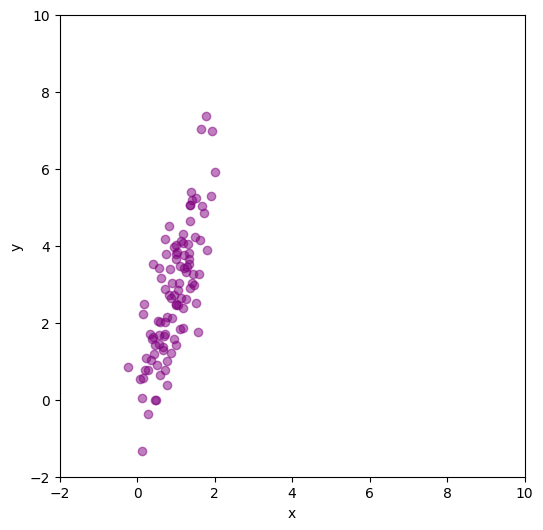

In [6]:
np.random.seed(100) # scipyと共通，乱数発生の再現性を得る

m = 1.0 # mean, 平均値
std = 0.5  # standard deviation, 標準偏差
N = 100
# norm.rvs: 平均 m, 標準偏差 std　の正規分布に従う確率変数をサンプルサイズ N で生成
x = norm.rvs(loc=m, scale=std, size=N)
y = 3*x + norm.rvs(loc=0, scale=2*std, size=N)
fig = plt.subplots(figsize=(6,6))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.plot(x,y, 'o', color="purple", alpha=0.5)

In [7]:
## vstack で配列を縦に結合する
## (今回は必ずしも必要ないが、ついでに、、)

## まずは vstack の使い方から

## ２つの２次元配列を作る
a = np.arange(6).reshape(2,3)  ## 2人x3教科
b = np.arange(12).reshape(4,3) ## 4人x3教科
print("----")
print("a = \n", a)
print("----")
print("b = \n", b)
print("----")

c = np.vstack([a,b]) ## 6人x3教科 (リストでなくタブルで渡しても良い)
print("----")
print("c = \n", c)
print("転置したc = \n", c.T)
print("----")


----
a = 
 [[0 1 2]
 [3 4 5]]
----
b = 
 [[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]
----
----
c = 
 [[ 0  1  2]
 [ 3  4  5]
 [ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]
転置したc = 
 [[ 0  3  0  3  6  9]
 [ 1  4  1  4  7 10]
 [ 2  5  2  5  8 11]]
----


In [9]:
## x = [x0, x1, ... , xN-1]
## y = [y0, y1, ... , yN-1]　　実際はarray型
## から
## X = [[x0, y0], [x1, y1], ...] のような２次元配列を作りたい

Xtmp = np.vstack([x,y]).T ## (x0, y0), (x1, y1), ... (xN-1, yN-1) の array を作成
X = np.array([x,y]).T
##. X と Xtmp は同じ


In [10]:
%whos


Variable    Type        Data/Info
---------------------------------
DataFrame   type        <class 'pandas.core.frame.DataFrame'>
N           int         100
PCA         ABCMeta     <class 'sklearn.decomposition._pca.PCA'>
Series      type        <class 'pandas.core.series.Series'>
X           ndarray     100x2: 200 elems, type `float64`, 1600 bytes
Xtmp        ndarray     100x2: 200 elems, type `float64`, 1600 bytes
a           ndarray     2x3: 6 elems, type `int64`, 48 bytes
b           ndarray     4x3: 12 elems, type `int64`, 96 bytes
c           ndarray     6x3: 18 elems, type `int64`, 144 bytes
fig         tuple       n=2
m           float       1.0
norm        norm_gen    <scipy.stats._continuous_<...>object at 0x7b3dffe07df0>
np          module      <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
pd          module      <module 'pandas' from '/u<...>ages/pandas/__init__.py'>
plt         module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
sp          modul

In [11]:
X.shape

(100, 2)

In [12]:
# 指定した列を取り出す
# x0, x1, ... を取り出す
X[:,0]  ## 0番目の列、行はすべて(:で指定)

array([ 0.12511726,  1.1713402 ,  1.5765179 ,  0.87378198,  1.49066039,
        1.25710942,  1.11058983,  0.46497833,  0.90525208,  1.12750072,
        0.77098651,  1.21758174,  0.70820247,  1.40842354,  1.3363604 ,
        0.94779443,  0.73435981,  1.51486634,  0.78093219,  0.44084088,
        1.80949083,  1.77080259,  0.87406043,  0.57878213,  1.09225935,
        1.4685411 ,  1.36550017,  1.68077806,  0.83688097,  1.02783801,
        1.1111998 ,  0.2783915 ,  0.62182385,  1.40822701,  1.37522238,
        0.77202654,  1.59481113,  0.15469159,  0.32180048,  0.38378274,
        0.72778042,  0.66591413,  1.00365728,  0.69353063,  1.64987404,
        0.13345219,  0.50834495,  1.17875388,  0.19321075,  1.73535693,
        0.4059912 ,  0.7251269 ,  0.52997692,  0.58603382,  1.05443173,
        1.2539048 ,  0.56888633,  1.62473487,  0.96019438,  0.55513426,
        0.55910081,  1.00931947,  1.11892231,  1.00677427,  0.1822353 ,
        0.47789506,  1.30651944,  1.36810261,  1.51346072,  0.28

In [13]:
# 指定した行を取り出す
X[0,:]  ## 0番目の行、列はすべて(:で指定)

array([ 0.12511726, -1.32929942])

### 相関係数

共分散
$S_{xy} = \frac{1}{n}\Sigma_{i=1}^{n} (x_i - \bar{x})(y_i-\bar{y})$

In [19]:
# 相関係数を計算しておく

# 平均
X_mean = np.mean(X, axis=0)   ## axis=0 で 0〜N までのサンプル方向の平均をとる
print('mean : ', X_mean)


## 共分散行列 COV
## COV = [ [Sxx, Sxy], [Syx, Syy] ]
##
COV = np.cov(X[:,0], X[:,1], bias=0)
## bias=0は不偏分散（n-1で割る)　　なお、上の Sxy のように n で割るのは標本分散

np.set_printoptions(precision=3)
print('covariance matrix : ', COV)  ##[00 01] [10 11]
## 相関係数 correlation coefficient
corr_coef = COV[0][1]/np.sqrt(COV[0][0]*COV[1][1])
print('correlation coefficient: {0:.3f}'.format(corr_coef))
## numpy の corrcoef を用いても良い（corrcoef: 相関関数行列の計算）
np.corrcoef(X.T)


mean :  [0.948 2.774]
covariance matrix :  [[0.237 0.628]
 [0.628 2.775]]
correlation coefficient: 0.774


array([[1.   , 0.774],
       [0.774, 1.   ]])

### sklearnで PCA を実行

変数の標準化で、分散を
$x_n$と$y_n$で揃えるスケール変換をすることもあるが、ここではそのまま、PCAを実行する。

In [20]:
pca = PCA(n_components=2)   ## sklearn.decomposition の PCA
pca.fit(X)

PCA(n_components=2)

In [21]:
## 固有ベクトル：　 PCA で発見された新しい特徴空間の軸の向き
print('[第１主成分の方向ベクトル] [第２主成分の方向ベクトル]')
print(pca.components_) ## [第１主成分の方向ベクトル] [第２主成分の方向ベクトル]

print('X の分散 : ')
print(pca.get_covariance())

## [第１主成分の分散] [第２主成分の分散]
print('各主成分の分散 : ',  pca.explained_variance_)
## [第１主成分の分散の割合] [第２主成分の分散の割合]
print('各主成分の分散割合 : ',  pca.explained_variance_ratio_ *100, " %")

[第１主成分の方向ベクトル] [第２主成分の方向ベクトル]
[[ 0.228  0.974]
 [ 0.974 -0.228]]
X の分散 : 
[[0.237 0.628]
 [0.628 2.775]]
各主成分の分散 :  [2.922 0.091]
各主成分の分散割合 :  [96.995  3.005]  %


### 固有ベクトルの表示

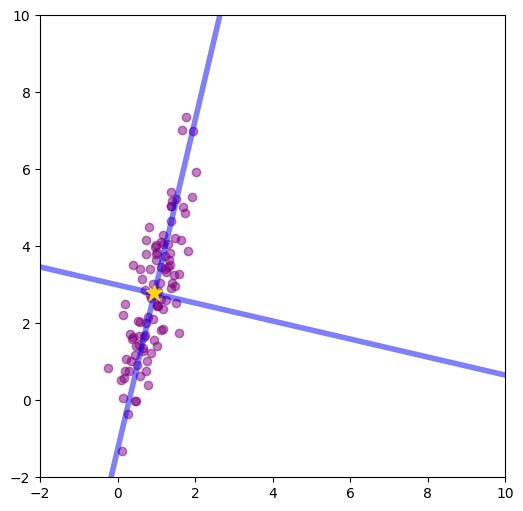

In [22]:
fig = plt.subplots(figsize=(6,6))
#plt.xlabel('x')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.plot(x,y, 'o', color="purple", alpha=0.5)

## 固有ベクトルで張られた新しい空間の軸をプロット
dx = plt.xlim()[1]-plt.xlim()[0]
for evec in pca.components_:
  uu = pca.mean_ + 2*dx*evec
  dd = pca.mean_ - 2*dx*evec
  plt.plot([dd[0], uu[0]], [dd[1], uu[1]] , '-', lw=4, c="blue", alpha=0.5)

#plt.plot(pca.mean_[0], pca.mean_[1], 'D', markersize=10, color="gold")
plt.plot(pca.mean_[0], pca.mean_[1], '*', markersize=12, color="gold")

### 新しい特徴量空間にデータを変換

-4.182363570484163
0.13356277874114308
[-4.182  0.134]
-0.33443656741526684
0.30770853686687755
[-0.334  0.308]


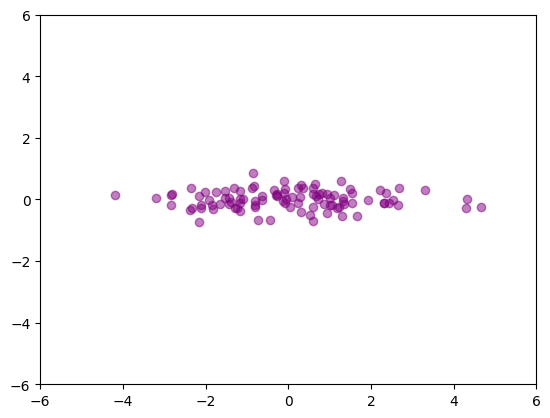

In [23]:
## pca.transform:
## 各エントリー毎に、平均を (0,0) に持っていった後に、固有ベクトルとの内積をとって、座標変換
X_trans = pca.transform(X)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.plot(X_trans[:,0], X_trans[:, 1], 'o', color="purple", alpha=0.5)

## transform(X) の作業を自分で行ってみる
Z = X - X_mean

print(pca.components_[0].dot(Z[0,:])) ## X_trans の意味
print(pca.components_[1].dot(Z[0,:]))
print(X_trans[0,:])

print(pca.components_[0].dot(Z[1,:])) ## X_trans の意味
print(pca.components_[1].dot(Z[1,:]))
print(X_trans[1,:])



## PCA: ３次元の場合

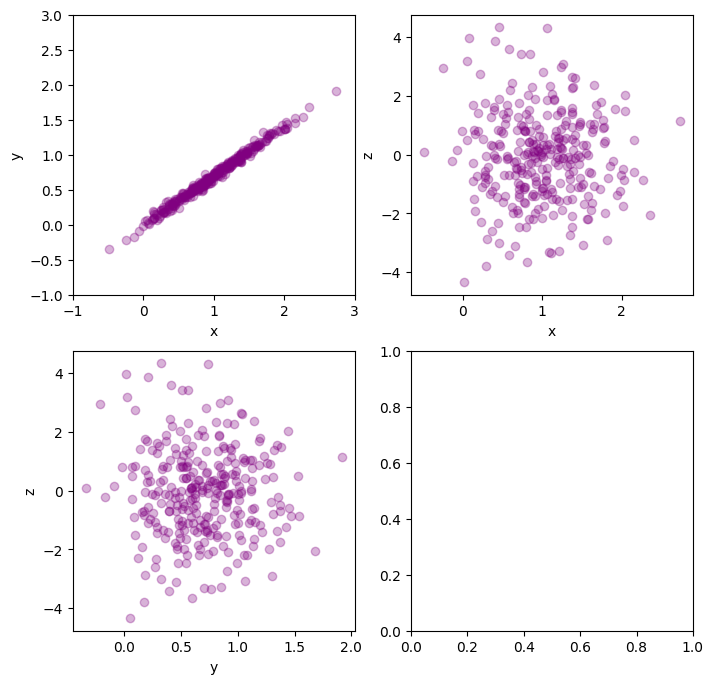

In [24]:
np.random.seed(100) # scipyと共通，乱数発生の再現性を得る
m = 1.0 # mean, 平均値
std = 0.5  # standard deviation, 標準偏差
N = 300
x = norm.rvs(loc=m, scale=std, size=N)
y = 0.7*(x + norm.rvs(loc=0, scale=0.1*std, size=N))
z = norm.rvs(loc=0, scale=3*std, size=N)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axs[0, 0].set_xlim(-1, 3)
axs[0, 0].set_ylim(-1, 3)
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("z")
axs[1, 0].set_xlabel("y")
axs[1, 0].set_ylabel("z")
axs[0, 0].plot(x,y, 'o', color="purple", alpha=0.3) # upper left
axs[0, 1].plot(x,z, 'o', color="purple", alpha=0.3) # upper right
axs[1, 0].plot(y,z, 'o', color="purple", alpha=0.3) # lower left
#plt.ylim(-1, 3)

In [25]:
## ３次元の scatter plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
X, Y = np.mgrid[-1:4, -1:4]
def f(x, y):
  return x*0
Z = f(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.3)
ax.set_xlim3d(-1, 3)
ax.set_ylim3d(-1, 3)
ax.set_zlim3d(-2, 2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.plot(x,y,z,marker="o",linestyle='None', alpha=0.6)

<Figure size 640x480 with 0 Axes>

In [26]:
X = np.vstack([x,y,z]).T ## (x0, y0, z0), (x1, y1, z1), ... (xN, yN, zN) の array を作成
np.set_printoptions(precision=2, floatmode='fixed', suppress=True)

print('相関関数行列')
print(np.corrcoef(X.T), "\n")
pca = PCA(n_components=3)   ## sklearn.decomposition の PCA
pca.fit(X)
print('各主成分の方向ベクトル')
print(pca.components_, '\n')
print('各主成分の分散 : ',  pca.explained_variance_, '\n')
print('各主成分の分散割合 : ',  pca.explained_variance_ratio_)

相関関数行列
[[ 1.00  0.99 -0.02]
 [ 0.99  1.00 -0.03]
 [-0.02 -0.03  1.00]] 

各主成分の方向ベクトル
[[-0.01 -0.01  1.00]
 [ 0.82  0.58  0.01]
 [-0.58  0.82  0.00]] 

各主成分の分散 :  [2.31 0.40 0.00] 

各主成分の分散割合 :  [0.85 0.15 0.00]


変数の**標準化**で、分散を
$x_n$と$y_n$で揃えるスケール変換をすることが多いが、ここではそのまま、PCAを実行する。


## PCA: 定番の適用例

定番の PCA の使用例として、次のような国語、英語、数学、理科のテストの点数、１０人分のデータが得られたとする。
出典：「多変量解析法入門」（永田靖・棟近雅彦著、サイエンス社）第９章主成分分析から

In [27]:
#data = {'国語':[86,71,42,62,96,39,50,78,51,89],
#        '英語':[79,75,43,58,97,33,53,66,44,92],
#        '数学':[67,78,39,98,61,45,64,52,76,93],
#        '理科':[68,84,44,95,63,50,72,47,72,91]}
data = {'J':[86,71,42,62,96,39,50,78,51,89],
        'E':[79,75,43,58,97,33,53,66,44,92],
        'M':[67,78,39,98,61,45,64,52,76,93],
        'S':[68,84,44,95,63,50,72,47,72,91]}
df = DataFrame(data)
df

,J,E,M,S
0,86,79,67,68
1,71,75,78,84
2,42,43,39,44
3,62,58,98,95
4,96,97,61,63
5,39,33,45,50
6,50,53,64,72
7,78,66,52,47
8,51,44,76,72
9,89,92,93,91


array([[<Axes: xlabel='J', ylabel='J'>, <Axes: xlabel='E', ylabel='J'>,
        <Axes: xlabel='M', ylabel='J'>, <Axes: xlabel='S', ylabel='J'>],
       [<Axes: xlabel='J', ylabel='E'>, <Axes: xlabel='E', ylabel='E'>,
        <Axes: xlabel='M', ylabel='E'>, <Axes: xlabel='S', ylabel='E'>],
       [<Axes: xlabel='J', ylabel='M'>, <Axes: xlabel='E', ylabel='M'>,
        <Axes: xlabel='M', ylabel='M'>, <Axes: xlabel='S', ylabel='M'>],
       [<Axes: xlabel='J', ylabel='S'>, <Axes: xlabel='E', ylabel='S'>,
        <Axes: xlabel='M', ylabel='S'>, <Axes: xlabel='S', ylabel='S'>]],
      dtype=object)

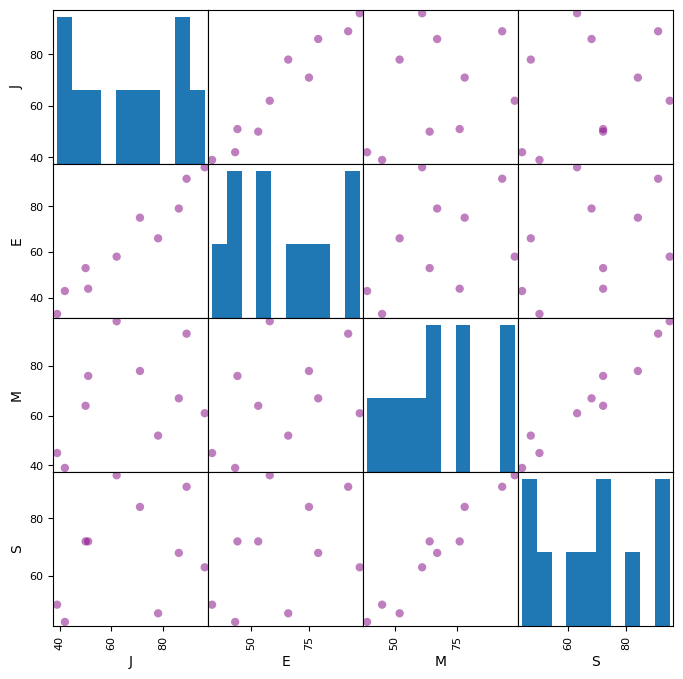

In [59]:
pd.plotting.scatter_matrix(df, figsize=(8, 8), marker='o', c='purple')


In [60]:
# 相関行列　 pandas では、np.corrcoeff() ではなく corr()
df.corr()

,J,E,M,S
J,1.000000,0.966984,0.376093,0.311276
E,0.966984,1.000000,0.414637,0.398275
M,0.376093,0.414637,1.000000,0.972129
S,0.311276,0.398275,0.972129,1.000000


In [61]:
pca = PCA(n_components=4)   ## sklearn.decomposition の PCA
pca.fit(df)
print('[各主成分の方向ベクトル]')
print(pca.components_) ## [第１主成分の方向ベクトル]、第２、第３、、、
print('X の分散 : ')
print(pca.get_covariance())
print('各主成分の分散 : ',  pca.explained_variance_)
print('各主成分の分散割合 : ',  pca.explained_variance_ratio_)

[各主成分の方向ベクトル]
[[-0.55 -0.59 -0.44 -0.40]
 [-0.44 -0.40  0.58  0.56]
 [ 0.55 -0.56  0.45 -0.43]
 [ 0.46 -0.42 -0.52  0.59]]
X の分散 : 
[[422.04 428.22 149.64 114.96]
 [428.22 464.67 173.11 154.33]
 [149.64 173.11 375.12 338.47]
 [114.96 154.33 338.47 323.16]]
各主成分の分散 :  [1092.01  470.01   21.03    1.94]
各主成分の分散割合 :  [0.69 0.30 0.01 0.00]


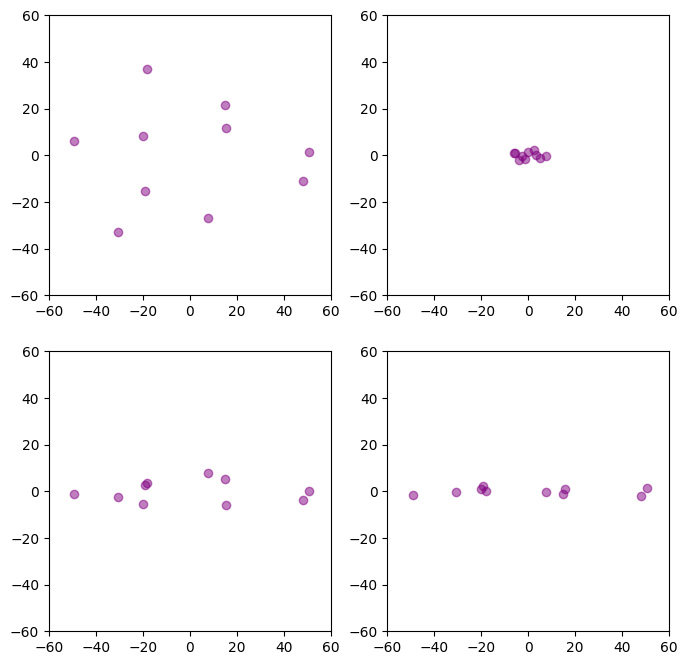

In [62]:
trans = pca.transform(df)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axs[0, 0].set_xlim(-60, 60)
axs[0, 0].set_ylim(-60, 60)
axs[0, 0].plot(trans[:,0], trans[:,1], 'o', color="purple", alpha=0.5)
axs[0, 1].set_xlim(-60, 60)
axs[0, 1].set_ylim(-60, 60)
axs[0, 1].plot(trans[:,2], trans[:,3], 'o', color="purple", alpha=0.5)
axs[1, 0].set_xlim(-60, 60)
axs[1, 0].set_ylim(-60, 60)
axs[1, 0].plot(trans[:,0], trans[:,2], 'o', color="purple", alpha=0.5)
axs[1, 1].set_xlim(-60, 60)
axs[1, 1].set_ylim(-60, 60)
axs[1, 1].plot(trans[:,0], trans[:,3], 'o', color="purple", alpha=0.5)

In [ ]:
#メモ（削除予定）
#df.sum(axis=1)/2.0

# Google Drive のマウント


Google Drive をマウントすることによって、画像ファイル、データファイルなどに Google Colab からアクセスするため、自分の Google Drive を**「マウント」**する。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

自分の Google Drive に、Colab_Files （名前は任意）というフォルダを作成し、そのフォルダ内にファイルをおけば、次のように Colab からアクセスできる。

In [ ]:
%ls drive/'My Drive'/Colab_Files/